<a href="https://colab.research.google.com/github/claudio1975/PyDataVenice/blob/main/EDA_stock_with_Agent_and_Perplexity_eow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U statsforecast==2.0.2 &>/dev/null

In [ ]:
!pip install yfinance=0.2.65 &>/dev/null

In [ ]:
! pip install pyautogen==0.7.0 &>/dev/null

In [ ]:
! pip install perplexityai &>/dev/null

### Prepare workspace

In [ ]:
# Yahoo Finance API
# ==============================================================================
import yfinance as yf

In [ ]:
# Handling and processing of Data
# ==============================================================================
import numpy as np
import pandas as pd
import scipy.stats as stats

# Handling and processing of Data for Date (time)
# ==============================================================================
import datetime
import time
from datetime import datetime, timedelta

# Statistics and plot
# ==============================================================================
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import normal_ad


In [ ]:
# Plot
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from utilsforecast.plotting import plot_series


In [ ]:
# PyAutogen & Perplexity
# ==============================================================================
from autogen import ConversableAgent
from perplexity import Perplexity


In [ ]:
# Utils
# ==============================================================================
import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings("ignore")


### Functions

In [ ]:
def augmented_dickey_fuller_test(series , column_name):
    print (f'Dickey-Fuller test results for columns: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of observations used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("The data is stationary")
    else:
        print("Conclusion:====>")
        print("The null hypothesis cannot be rejected")
        print("The data is not stationary")

In [ ]:
def plot_autocorrelation(data):
  fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
  plot_acf(data["y"],  lags=21, ax=axs[0],color="fuchsia")
  axs[0].set_title("Autocorrelation");
  plot_pacf(data["y"],  lags=21, ax=axs[1],color="lime")
  axs[1].set_title('Partial Autocorrelation')
  plt.tight_layout()
  plt.show()
  plt.close()

In [ ]:
# Function to plot boxplot
def plot_boxplot(data, var):
    # Extract month names for grouping
    data_reset = data.reset_index()
    data_reset['Month'] = data_reset['ds'].dt.strftime('%B')  # Full month name
    # To ensure months are in calendar order
    months_order = ['January', 'February', 'March', 'April', 'May', 'June',
                    'July', 'August', 'September', 'October', 'November', 'December']

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
    sns.boxplot(x='Month', y=var, data=data_reset, order=months_order, palette='Set3', ax=ax)
    ax.set_title("Stock price Distribution per Month - Box Plot", fontsize=12)
    ax.set_xlabel('Month', fontsize=10)
    ax.set_ylabel(var.capitalize(), fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    plt.close()



In [ ]:
def plot_lineplot(data):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
    ax.set_title("Stock Price Lineplot", fontsize=12)

    ax.plot(data['ds'], data['y'], label='Stock Price', color='tab:blue')

    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

    plt.xticks(rotation=45)
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    plt.close()



In [ ]:
#------------------------------------
# NVIDIA
#------------------------------------

In [ ]:
stock_name = "NVDA"
NVIDIA_ticker = yf.Ticker(stock_name)
NVIDIA_history = NVIDIA_ticker.history(period="5y")
NVIDIA_history.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-10-26 00:00:00-04:00,13.386137,13.651078,12.998819,13.101256,336896000,0.0,0.0
2020-10-27 00:00:00-04:00,13.265505,13.401092,13.151354,13.355980,250520000,0.0,0.0
2020-10-28 00:00:00-04:00,13.157835,13.219646,12.570628,12.588573,376520000,0.0,0.0
2020-10-29 00:00:00-04:00,12.799429,13.152601,12.711198,12.984365,320080000,0.0,0.0
2020-10-30 00:00:00-04:00,12.810896,12.897132,12.262569,12.495857,416820000,0.0,0.0
2020-11-02 00:00:00-05:00,12.619230,12.797685,12.357280,12.542464,299652000,0.0,0.0
2020-11-03 00:00:00-05:00,12.669823,13.065116,12.564395,12.979877,272900000,0.0,0.0
2020-11-04 00:00:00-05:00,13.348501,13.785417,13.296410,13.752268,410228000,0.0,0.0
2020-11-05 00:00:00-05:00,14.119396,14.295358,13.948418,14.116903,319028000,0.0,0.0


In [ ]:
NVIDIA = NVIDIA_history.copy()

# Reset the index
NVIDIA.reset_index(inplace=True)

# Ensure Date is a datetime object and format it
NVIDIA['Date'] = pd.to_datetime(NVIDIA['Date'])

# Select the necessary columns
NVIDIA = NVIDIA[['Date', 'Close']]

# Rename the 'Date' column to 'ds'
NVIDIA = NVIDIA.rename(columns={'Date': 'ds','Close':'y'})

NVIDIA["unique_id"] = "1"
NVIDIA.columns=["ds", "y", "unique_id"]

# Now df should have the index reset, Date formatted, and renamed to 'ds'
NVIDIA.head()

,ds,y,unique_id
0,2020-10-26 00:00:00-04:00,13.101256,1
1,2020-10-27 00:00:00-04:00,13.355980,1
2,2020-10-28 00:00:00-04:00,12.588573,1
3,2020-10-29 00:00:00-04:00,12.984365,1
4,2020-10-30 00:00:00-04:00,12.495857,1


In [ ]:
NVIDIA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype                           
---  ------     --------------  -----                           
 0   ds         1256 non-null   datetime64[ns, America/New_York]
 1   y          1256 non-null   float64                         
 2   unique_id  1256 non-null   object                          
dtypes: datetime64[ns, America/New_York](1), float64(1), object(1)
memory usage: 29.6+ KB


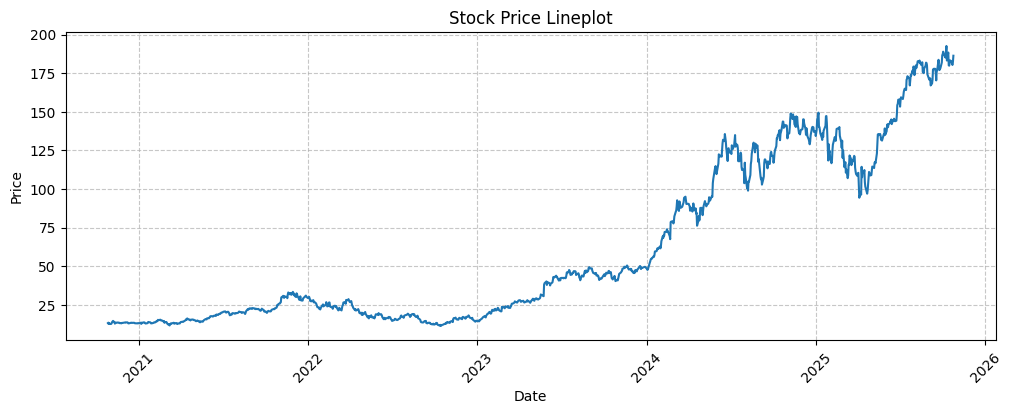

In [ ]:
plot_lineplot(NVIDIA)

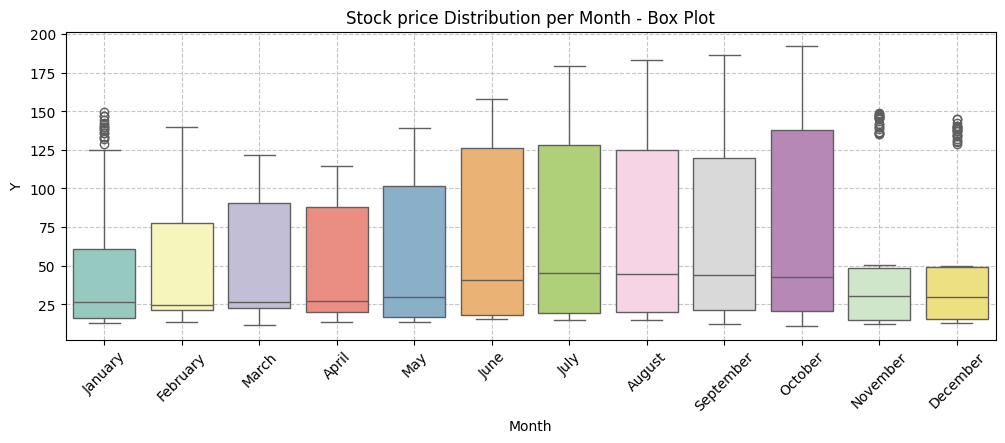

In [ ]:
plot_boxplot(NVIDIA,var='y')

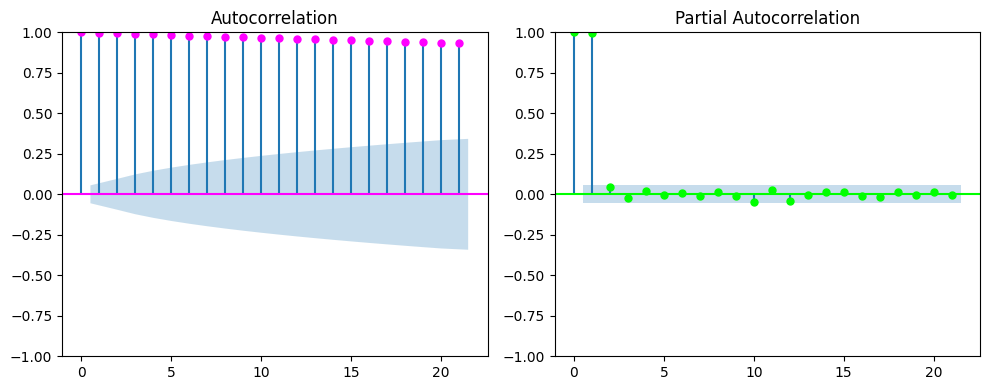

In [ ]:
plot_autocorrelation(NVIDIA)

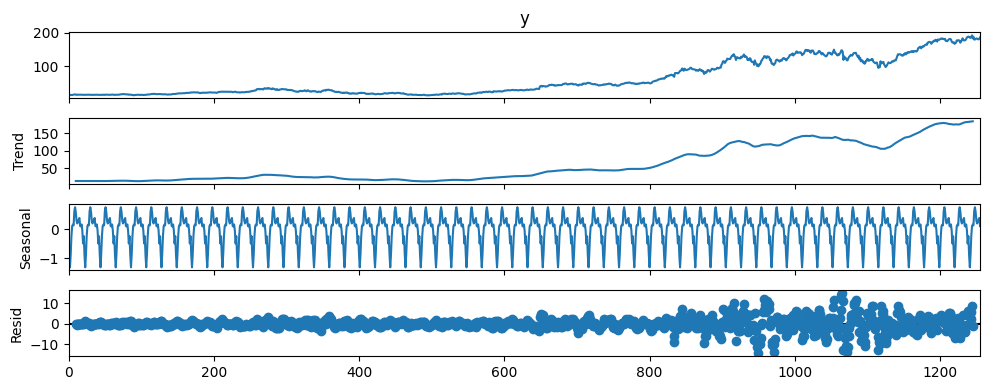

In [ ]:
plt.rcParams['figure.figsize']=(10,4)
m = seasonal_decompose(NVIDIA["y"], model = "Multiplicative", period=21).plot()
plt.show()
plt.close()

In [ ]:
augmented_dickey_fuller_test(NVIDIA["y"],'y')

Dickey-Fuller test results for columns: y
Test Statistic                    0.902278
p-value                           0.993120
No Lags Used                     20.000000
Number of observations used    1235.000000
Critical Value (1%)              -3.435656
Critical Value (5%)              -2.863883
Critical Value (10%)             -2.568018
dtype: float64
Conclusion:====>
The null hypothesis cannot be rejected
The data is not stationary


In [ ]:
#===================================
# Stock Agent Analysis
#===================================

In [ ]:
# Fetch 1-Year Historical Data for NVDA
ticker = yf.Ticker(stock_name)
history = ticker.history(period="1y")

# Process Historical Data for Key Indicators
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def process_history_data(hist):
    hist['20_SMA'] = hist['Close'].rolling(window=20).mean()
    hist['50_SMA'] = hist['Close'].rolling(window=50).mean()
    hist['100_SMA'] = hist['Close'].rolling(window=100).mean()
    hist['180_SMA'] = hist['Close'].rolling(window=180).mean()
    hist['250_SMA'] = hist['Close'].rolling(window=250).mean()
    hist['RSI'] = calculate_rsi(hist)

    latest_data = hist.iloc[-1]
    indicators = {
        'Current Price': latest_data['Close'],
        '20-day SMA': latest_data['20_SMA'],
        '50-day SMA': latest_data['50_SMA'],
        '100-day SMA': latest_data['100_SMA'],
        '180-day SMA': latest_data['180_SMA'],
        '250-day SMA': latest_data['250_SMA'],
        'RSI': latest_data['RSI'],
        'Volume': latest_data['Volume']
    }

    return indicators

indicators_summary = process_history_data(history)

# Print the latest key indicators
for key, value in indicators_summary.items():
    print(f"{key}: {value:.2f}")

Current Price: 186.26
20-day SMA: 184.67
50-day SMA: 179.59
100-day SMA: 171.15
180-day SMA: 148.23
250-day SMA: 145.24
RSI: 50.83
Volume: 130942300.00


In [ ]:
# Perplexity Configuration
root_folder="/content/"
_ = load_dotenv(root_folder + "perplexity.env") # read local .env file

client = Perplexity(api_key=os.getenv("PERPLEXITY_API_KEY")) # Uses PERPLEXITY_API_KEY from .env file

In [ ]:
# LLM Configuration
root_folder="/content/"
_ = load_dotenv(root_folder + "openai.env") # read local .env file

llm_api_key = os.getenv("OPENAI_API_KEY")
llm_config = {
    "model": "gpt-4o",
    "api_key": llm_api_key
}



In [ ]:
# Perplexity search
completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": f'Could you provide the behaviour and recommend the user to buy/sell/hold "{stock_name}" stock?',
        }
    ],
    model="sonar-pro",
    return_images=True,  # Enable image retrieval
    return_related_questions=True  # Optional: get related questions too
)
perplexity_output= completion.choices[0].message.content


In [ ]:
# Initialize ConversableAgent
agent = ConversableAgent(
    name="Chatbot",
    llm_config=llm_config,
    human_input_mode="NEVER",
)

# Define the Recommendation Task
selected_stock = stock_name
max_date = history.index.max().strftime('%Y-%m-%d')
task = (
    f"Analyze the following historical stock price data for {selected_stock} up to {max_date}.\n\n"
    f"Key Indicators:\n{indicators_summary}\n\n"
    "Based on this data, provide a clear indication on whether the stock is Bullish, Neutral, or Bearish."
    "Include relevant indicators and a brief explanation to support your indication."
    f"Use output from perplexity {perplexity_output}"
    f"Ensemble/compare information from {perplexity_output} and give a recomendations on the stock worth on buy/sell/hold"
    "You don't make predictions, only recommendations by analysis."
)


# Function to Generate Recommendation
def generate_recommendation(agent, task):
    try:
        reply = agent.generate_reply(
            messages=[
                {
                    "role": "user",
                    "content": task
                }
            ]
        )
        return reply
    except Exception as e:
        print(f"An error occurred while generating the recommendation: {e}")
        return None


# Generate and display the recommendation
if agent:
    recommendation = generate_recommendation(agent, task)
    if recommendation:
        print("Recommendation:")
        print(recommendation)
else:
    print("ConversableAgent is not initialized properly.")


Recommendation:
To determine whether NVIDIA (NVDA) stock is currently Bullish, Neutral, or Bearish, let's analyze the provided key indicators and relevant stock behavior:

### Key Indicators Analysis:
1. **Current Price vs. Moving Averages**:
   - **Current Price**: $186.26
   - **20-day SMA**: $184.67
   - **50-day SMA**: $179.59
   - **100-day SMA**: $171.15
   - **180-day SMA**: $148.23
   - **250-day SMA**: $145.24

   The current price is above all the listed moving averages, which typically indicates a general upward trend or bullish sentiment in the stock. The stock's short-term moving average (20-day SMA) is also above the longer-term moving averages (e.g., 100-day and 250-day SMA), further reinforcing the bullish momentum.

2. **Relative Strength Index (RSI)**:
   - **RSI**: 50.83

   An RSI of 50.83 suggests a neutral position, as it's neither in the overbought (>70) nor oversold (<30) territory. This implies that the stock is not facing immediate buying or selling pressure b